In [29]:
%load_ext autoreload
%autoreload 1

import sys,os
sys.path.append(sys.path[0]+'/../../utils/')

import numpy as np
from polytope import polytope
from utils import system, dlqr
import pdb
import matplotlib.pyplot as plt
from fnc.mpc import MPC
from matplotlib import rc
from fnc.build_robust_invariant import BuildRobustInvariant
from fnc.build_control_invariant import BuildControlInvariant
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initialize system parameters

In [30]:
A = np.array([[1, 1],
	          [0, 1]]);
B = np.array([[0], 
			  [1]]);


w_inf = 0.1  # infinity norm of the disturbance

alpha = 3

bx =  []
bx.append( 10*np.ones(A.shape[1])) # max state box constraints
bx.append(-10*np.ones(A.shape[1])) # min state box constraints

bu = []
bu.append(2.0*np.ones(B.shape[1]))  # max input box constraints
bu.append(-2.0*np.ones(B.shape[1]))  # max input box constraints

Q      = np.eye(2)
R      = 0.1*np.eye(1)

# Part I: Compute robust invariant from data of an uncertain system

In [31]:
# Compute robust invariant from data
maxRollOut = 50
maxTime    = 40
maxIt      = 20

x0    = np.array([-0.0, 0.0])   # initial condition
sys        = system(A, B, w_inf, x0) # initialize system object
sys_aug    = system(A, B, alpha * w_inf, x0) # initialize system object

verticesW = sys.w_v # Vertices of true disturbance
build_robust_invariant = BuildRobustInvariant(A, B, A, B, Q, R, bx, bu, verticesW, maxIt, maxTime, maxRollOut, sys_aug)
build_robust_invariant.build_robust_invariant()

Disturbance vertices 
 [[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Disturbance vertices 
 [[-0.3 -0.3]
 [ 0.3 -0.3]
 [-0.3  0.3]
 [ 0.3  0.3]]
Compute robust invariant
Start roll out:  0  of iteration:  0
Start roll out:  1  of iteration:  0
Start roll out:  2  of iteration:  0
Start roll out:  3  of iteration:  0
Start roll out:  4  of iteration:  0
Start roll out:  5  of iteration:  0
Start roll out:  6  of iteration:  0
Start roll out:  7  of iteration:  0
Start roll out:  8  of iteration:  0
Start roll out:  9  of iteration:  0
Start roll out:  10  of iteration:  0
Start roll out:  11  of iteration:  0
Start roll out:  12  of iteration:  0
Start roll out:  13  of iteration:  0
Start roll out:  14  of iteration:  0
Start roll out:  15  of iteration:  0
Start roll out:  16  of iteration:  0
Start roll out:  17  of iteration:  0
Start roll out:  18  of iteration:  0
Start roll out:  19  of iteration:  0
Start roll out:  20  of iteration:  0
Start roll out:  21  of iteration: 

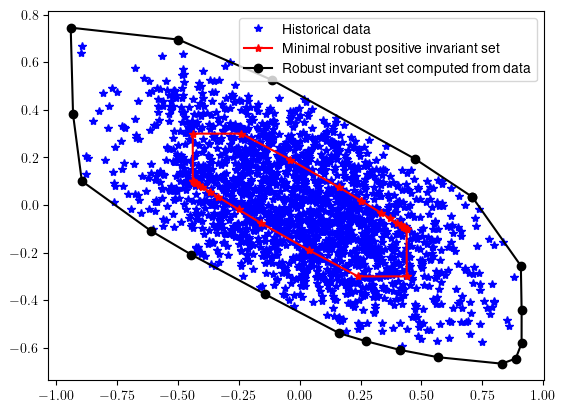

In [32]:
plt.figure()
for it in range(0, len(build_robust_invariant.x_cl)):
    if it == 0:
        plt.plot(build_robust_invariant.x_cl[it][:,0], build_robust_invariant.x_cl[it][:,1], '*b', label='Historical data')
    else:
        plt.plot(build_robust_invariant.x_cl[it][:,0], build_robust_invariant.x_cl[it][:,1], '*b')
minimal_RPI = polytope(vertices=build_robust_invariant.verticesO)
data_RPI = polytope(vertices=np.array(build_robust_invariant.x_data))
minimal_RPI.plot2DPolytope('r', linestyle='-*', label = 'Minimal robust positive invariant set')
data_RPI.plot2DPolytope('k', linestyle='-o', label = 'Robust invariant set computed from data')
plt.legend()

# Part II: Compute a control invariant from data of an uncertain system

In [33]:
# Robust tube MPC with robust invariant computed from data as terminal constraint
N  = 5
Qf = np.eye(2)

# Initialize mpc parameters
build_robust_invariant.shrink_constraint()
mpc = MPC(N, A, B, Q, R, Qf, 
			build_robust_invariant.bx_shrink, 
			build_robust_invariant.bu_shrink, 
			build_robust_invariant.K, 
			np.array(build_robust_invariant.x_data),
			np.array(build_robust_invariant.x_data)
			)

x0    = np.array([-9, 1.0])   # initial condition
sys        = system(A, B, w_inf, x0) # initialize system object

# =============================
# Compute control invariant from data
x_cl = []; u_cl = [];
maxRollOut = 50
maxTime    = 10
maxIt      = 10

build_control_invariant = BuildControlInvariant(A, B, maxIt, maxTime, maxRollOut,
												sys, mpc, 
												build_robust_invariant.x_data.copy(),
												build_robust_invariant.u_data.copy(),
												store_all_data_flag = True)

build_control_invariant.build_control_invariant()

shrunk state constraints max:  [9.08807867 9.25463526]
shrunk state constraints min:  [-9.05881145 -9.33317032]
shrunk input constraints max:  [1.21405121]
shrunk input constraints min:  [-1.26129319]
Initializing FTOCP
Done initializing FTOCP
Disturbance vertices 
 [[-0.1 -0.1]
 [ 0.1 -0.1]
 [-0.1  0.1]
 [ 0.1  0.1]]
Start roll out:  0  of iteration:  0
Start roll out:  1  of iteration:  0
Start roll out:  2  of iteration:  0
Start roll out:  3  of iteration:  0
Start roll out:  4  of iteration:  0
Start roll out:  5  of iteration:  0
Start roll out:  6  of iteration:  0
Start roll out:  7  of iteration:  0
Start roll out:  8  of iteration:  0
Start roll out:  9  of iteration:  0
Start roll out:  10  of iteration:  0
Start roll out:  11  of iteration:  0
Start roll out:  12  of iteration:  0
Start roll out:  13  of iteration:  0
Start roll out:  14  of iteration:  0
Start roll out:  15  of iteration:  0
Start roll out:  16  of iteration:  0
Start roll out:  17  of iteration:  0
Start 

(-4.0, 4.0)

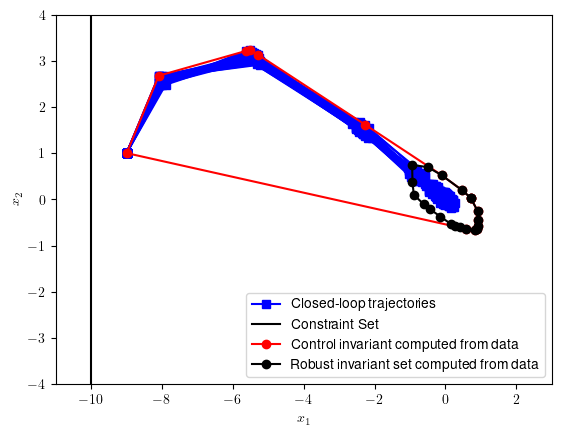

In [34]:
plt.figure()
for x in build_control_invariant.x_cl_data:
    plt.plot(x[:,0], x[:,1], '-sb')
plt.plot(build_control_invariant.x_cl_data[0][:,0], build_control_invariant.x_cl_data[0][:,1], '-sb', label = 'Closed-loop trajectories')
X = polytope(F=np.vstack([np.eye(2), -np.eye(2)]), b=np.hstack([bx[0], -bx[1]]))
CS = polytope(vertices=np.array(build_control_invariant.x_data))
X.plot2DPolytope('k', linestyle='-', label = 'Constraint Set')
CS.plot2DPolytope('r', linestyle='-ob', label = 'Control invariant computed from data')
data_RPI.plot2DPolytope('k', linestyle='-o', label = 'Robust invariant set computed from data')
plt.legend()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
ax = plt.gca()
ax.set_xlim([-11, 3])
ax.set_ylim([-4, 4])